In [67]:
import sys
sys.path.append("/global/u2/r/ritesh11/GSOC_2025/")

In [68]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import re

from Flash.tokenizer import Tokenizer
from Flash.constants import SPECIAL_SYMBOLS, PAD_IDX, UNK_IDX, T_IDX, BOS_IDX, EOS_IDX, SEP_IDX

In [69]:
df = pd.read_csv("/pscratch/sd/r/ritesh11/EW/data/EW_2-2-3valid.csv")
res_dir = "/pscratch/sd/r/ritesh11/EW/data/EW_2-2-3_simplified_termwisevalid.csv"

In [70]:
tokenizer = Tokenizer(df,100,SPECIAL_SYMBOLS,UNK_IDX,False)

In [71]:
def split_expression(expr: str):
    terms = []
    current = []
    depth = 0
    i = 0
    while i < len(expr):
        char = expr[i]

        if char == '(':
            depth += 1
            current.append(char)
        elif char == ')':
            depth -= 1
            current.append(char)
        elif char in '+-' and depth == 0:
            if current:
                terms.append(''.join(current).strip())
                current = [char] if char == '-' else []
            else:
                current.append(char) 
        else:
            current.append(char)
        i += 1

    if current:
        terms.append(''.join(current).strip())

    return [term for term in terms if term]

In [72]:
def split_term_by_top_level_mul(term):
    """
    Split at * only if it appears at top-level and between two parenthesis blocks: )*(.
    Also extract common divisors of the form (...) / (...) if '/' is at top-level.
    """
    parts = []
    depth = 0
    curr = ''
    n = len(term)
    common_divisor = None
    i = 0

    while i < n:
        c = term[i]
        
        # Update depth
        if c == '(':
            depth += 1
        elif c == ')':
            depth -= 1

        # Check for top-level )*( pattern
        if (
            c == '*' and depth == 0
            and i > 0 and i < n - 1
            and term[i - 1] == ')' and term[i + 1] == '('
        ):
            if curr.strip():
                parts.append(curr.strip())
            curr = ''
            i += 1
            continue

        # Check for top-level )/( pattern (common divisor)
        if (
            c == '/' and depth == 0
            and i > 0 and i < n - 1
            and term[i - 1] == ')' and term[i + 1] == '('
        ):
            if curr.strip():
                parts.append(curr.strip())
            # Everything after '/' is the common divisor
            common_divisor = term[i + 1:].strip()
            break  # Do not add '/' to curr, exit here

        curr += c
        i += 1

    if curr.strip() and not common_divisor:
        parts.append(curr.strip())

    return parts, common_divisor

In [73]:
def tokenize_split_expression(expr: str) -> list:
    """
    Splits a symbolic algebraic expression into top-level terms,
    respecting parentheses and nested expressions.
    """
    terms = []
    current = []
    depth = 0
    i = 0
    expr = tokenizer.tgt_tokenize(expr)
    while i < len(expr):
        char = expr[i]

        if char == '(':
            depth += 1
            current.append(char)
        elif char == ')':
            depth -= 1
            current.append(char)
        elif char == 'i' or char =='e':
            depth=0
            current.append(char)
            
        elif char in '+-' and depth == 0:
            # If '+' or '-' is at top level, treat as separator
            if current:
                terms.append(''.join(current).strip())
                current = [char] if char == '-' else []
            else:
                current.append(char)  # for unary minus at start
        else:
            current.append(char)
        i += 1

    if current:
        terms.append(''.join(current).strip())

    return [term for term in terms if term]

In [74]:
def check_parentheses_balance(expr):
    depth = 0
    for i, c in enumerate(expr):
        if c == '(':
            depth += 1
        elif c == ')':
            depth -= 1
            if depth < 0:
                return f"Unmatched closing parenthesis at position {i}"
    if depth > 0:
        return f"{depth} unmatched opening parenthesis(es)"
    elif depth < 0:
        return f"{-depth} unmatched closing parenthesis(es)"
    else:
        return True

In [75]:
lens = []
exps = []
for sqamp in tqdm(df.sqamp.tolist()):
    temp = [e for e in split_expression(sqamp)]
    exps.append(temp)
    lens.append(len(temp))

100%|██████████| 20961/20961 [00:04<00:00, 5096.13it/s]


In [76]:
split_exps = [] 
for exp in tqdm(exps):
    temp_exp_list = []
    for e in exp:
        temp = split_term_by_top_level_mul(e)
        temp_exp_list.append(temp)
    split_exps.append(temp_exp_list)

100%|██████████| 20961/20961 [00:03<00:00, 5550.49it/s]


In [77]:
simpl_exps = []

In [78]:
for exp in tqdm(split_exps):
    temp = []
    for e in exp:
        term = e[0][0]
        temp.append(tokenize_split_expression(term))
    simpl_exps.append(temp)

100%|██████████| 20961/20961 [00:03<00:00, 6369.81it/s]


In [79]:
for exp_idx, exp in enumerate(simpl_exps):
    for e_idx, e in enumerate(exp):
        if len(e) > 1:
            s = e[0]
            i_pos = min((s.find('i') if 'i' in s else float('inf')),
                        (s.find('e') if 'e' in s else float('inf')))
            if i_pos == float('inf'):
                raise ValueError(f"No 'i' or 'e' found in e[0] at simpl_exps[{exp_idx}][{e_idx}] → e[0] = {s}")
            
            # Look for first '(' after first 'i' or 'e'
            open_paren_pos = s.find('(', i_pos)
            if open_paren_pos == -1:
                raise ValueError(f"No '(' found after 'i'/'e' in e[0] at simpl_exps[{exp_idx}][{e_idx}] → e[0] = {s}")

            prefix = s[:open_paren_pos]
            assert "i" in prefix or "e" in prefix, \
                f"Assertion failed at simpl_exps[{exp_idx}][{e_idx}] → prefix = '{prefix}', e = {e}"

            e[0] = e[0] + ")"
            e[-1] = prefix + "(" + e[-1]
            for i in range(1, len(e) - 1):
                e[i] = prefix + "(" + e[i] + ")"

In [80]:
for i in range(len(simpl_exps)):
    for j in range(len(simpl_exps[i])):
        mul = ""
        div = split_exps[i][j][1]
        if len(split_exps[i][j][0]) > 1:
            for m in split_exps[i][j][0][1:]:
                mul= mul + "*" + m
        for k,exp in enumerate(simpl_exps[i][j]):
            if mul:
                exp = exp + "*" + mul
            if div:
                exp = exp + "/" + div
            simpl_exps[i][j][k] = exp

In [81]:
for i, exp in enumerate(simpl_exps):
    simpl_exps[i] = [item for sublist in exp for item in sublist]

In [82]:
for e in tqdm(simpl_exps):
    for exp in e:
        assert check_parentheses_balance(exp)

100%|██████████| 20961/20961 [00:01<00:00, 10645.67it/s]


In [83]:
# Special token indices
BOS_IDX = 0  # Beginning of Sequence
PAD_IDX = 1  # Padding
EOS_IDX = 2  # End of Sequence
UNK_IDX = 3  # Unknown Token
SEP_IDX = 4  # Separator Token

T_IDX = [i for i in range(5,105)]


# Special token symbols
SPL_TERM_SYMBOLS = [f'<T{i}>' for i in range(100)]
SPECIAL_SYMBOLS = ['<BOS>', '<PAD>', '<EOS>', '<UNK>', '<SEP>'] + SPL_TERM_SYMBOLS

In [84]:
SPECIAL_SYMBOLS[5]

'<T0>'

In [85]:
for exp in tqdm(simpl_exps):
    for i in range(len(exp)):
        if i==0:
            if(len(exp) == 1):
                exp[i] = SPECIAL_SYMBOLS[BOS_IDX] + exp[i] + SPECIAL_SYMBOLS[EOS_IDX]
            else:
                exp[i] = SPECIAL_SYMBOLS[BOS_IDX] + exp[i] + SPECIAL_SYMBOLS[SEP_IDX]
        elif i==len(exp)-1:
            exp[i] = SPECIAL_SYMBOLS[T_IDX[i]] + exp[i] + SPECIAL_SYMBOLS[EOS_IDX]
        else:
            exp[i] = SPECIAL_SYMBOLS[T_IDX[i]] + exp[i] + SPECIAL_SYMBOLS[SEP_IDX]

100%|██████████| 20961/20961 [00:00<00:00, 415871.06it/s]


In [86]:
simpl_exps[12]

['<BOS>16/81*e^4*MOMENTUM_14*MOMENTUM_23*(m_u^2+MOMENTUM_12+1/2*reg_prop)^(-2)<EOS>']

In [87]:
amps = df.amp.tolist()

In [88]:
data = {"amp":[], "sqamp":[]}

In [89]:
for a,sqa in zip(amps,simpl_exps):
    for e in sqa:
        data['amp'].append(a)
        data['sqamp'].append(e)

In [90]:
df_new = pd.DataFrame(data)

In [91]:
df_new

,amp,sqamp
0,"1/3*i*e^2*P_L_{ % INDEX_0, % INDEX_1}*P_R_{ % ...",<BOS>4/9*e^4*MOMENTUM_14*MOMENTUM_23*(m_u^2+MO...
1,-1/6*i*2^(1/2)*e*(e*sin(theta_W)/cos(theta_W)+...,<BOS>1/36*e^2*m_d^2*(MOMENTUM_12+-1/2*m_W^(-2)...
2,-1/6*i*2^(1/2)*e*(e*sin(theta_W)/cos(theta_W)+...,<T1>-1/36*i*2^(1/2)*e*(e*sin_theta_W/cos_theta...
3,-1/6*i*2^(1/2)*e*(e*sin(theta_W)/cos(theta_W)+...,<T2>-1/36*i*2^(3*e*cos_theta_W/sin_theta_W)**(...
4,-1/6*i*2^(1/2)*e*(e*sin(theta_W)/cos(theta_W)+...,<T3>1/36*i*2^(1/2)*e*(e*sin_theta_W/cos_theta_...
...,...,...
104146,-1/4*i*e^3*m_e^2*(1+1/2*cos(theta_W)^(-2)*sin(...,<BOS>1/12*e^6*m_e^4*(1+1/2*m_W3^(-4)*MOMENTUM_...
104147,-1/4*i*e^3*m_e^2*(1+1/2*cos(theta_W)^(-2)*sin(...,<BOS>1/12*e^6*m_e^4*(1+1/2*m_W3^(-4)*MOMENTUM_...
104148,-1/4*i*e^3*m_e^2*(1+1/2*cos(theta_W)^(-2)*sin(...,<BOS>1/12*e^6*m_e^4*(1+1/2*m_W3^(-4)*MOMENTUM_...
104149,-1/4*i*e^3*m_e^2*(1+1/2*cos(theta_W)^(-2)*sin(...,<BOS>1/12*e^6*m_e^4*(1+1/2*m_W3^(-4)*MOMENTUM_...


In [92]:
df_new.to_csv(res_dir,index=False)

In [34]:
lens = []

In [35]:
for e in tqdm(simpl_exps):
    lens.append(len(e))

100%|██████████| 209140/209140 [00:00<00:00, 3496270.31it/s]


In [36]:
lens = np.array(lens)

In [37]:
np.argmax(lens)

np.int64(14929)

In [33]:
len(simpl_exps)

209140

In [38]:
simpl_exps[14929]

['<BOS>-1/64*i*e*(e*sin_theta_W/cos_theta_W)/((m_e^2+-1/2*m_W3^2+-MOMENTUM_24+1/2*reg_prop)*(m_e^2+-MOMENTUM_23+-MOMENTUM_24+MOMENTUM_34+1/2*reg_prop))<SEP>',
 '<T1>-1/64*i*e*(-e*cos_theta_W/sin_theta_W)^2*(i*e*m_e^2*MOMENTUM_12*MOMENTUM_34*(e*sin_theta_W/cos_theta_W)/((m_e^2+-1/2*m_W3^2+-MOMENTUM_24+1/2*reg_prop)*(m_e^2+-MOMENTUM_23+-MOMENTUM_24+MOMENTUM_34+1/2*reg_prop))<SEP>',
 '<T2>-1/64*i*e*(-e*cos_theta_W/sin_theta_W)^2/((m_e^2+-1/2*m_W3^2+-MOMENTUM_24+1/2*reg_prop)*(m_e^2+-MOMENTUM_23+-MOMENTUM_24+MOMENTUM_34+1/2*reg_prop))+-i*e*m_e^2*MOMENTUM_14*MOMENTUM_34*(e*sin_theta_W/cos_theta_W)/((m_e^2+-1/2*m_W3^2+-MOMENTUM_24+1/2*reg_prop)*(m_e^2+-MOMENTUM_23+-MOMENTUM_24+MOMENTUM_34+1/2*reg_prop))<SEP>',
 '<T3>-1/64*i*e*(-e*cos_theta_W/sin_theta_W)^2/((m_e^2+-1/2*m_W3^2+-MOMENTUM_24+1/2*reg_prop)*(m_e^2+-MOMENTUM_23+-MOMENTUM_24+MOMENTUM_34+1/2*reg_prop)))/((m_e^2+-1/2*m_W3^2+-MOMENTUM_24+1/2*reg_prop)*(m_e^2+-MOMENTUM_23+-MOMENTUM_24+MOMENTUM_34+1/2*reg_prop))<SEP>',
 '<T4>1/128*i*e*m

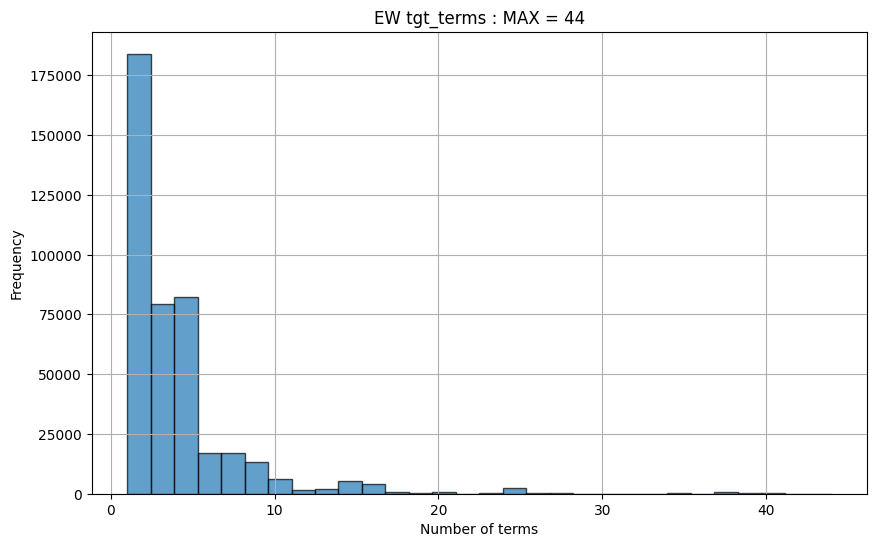

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(lens, bins=30, edgecolor='black', alpha=0.7)
plt.title(f'EW tgt_terms : MAX = {lens.max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [39]:
term_lens= []
for exp in tqdm(exps):
    for e in exp:
        term_lens.append(len(tokenizer.tgt_tokenize(e)))

100%|██████████| 209140/209140 [01:00<00:00, 3445.43it/s]


In [40]:
term_lens = np.array(term_lens)

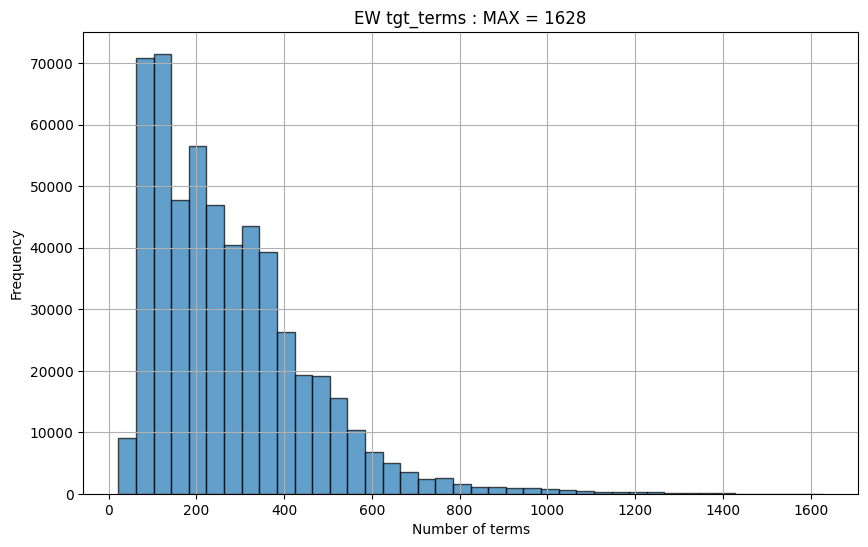

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(term_lens, bins=40, edgecolor='black', alpha=0.7)
plt.title(f'EW tgt_terms : MAX = {term_lens.max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [42]:
term_lens= []
for exp in tqdm(simpl_exps):
    for e in exp:
        term_lens.append(len(tokenizer.tgt_tokenize(e)))

100%|██████████| 209140/209140 [01:24<00:00, 2474.90it/s]


In [43]:
term_lens = np.array(term_lens)

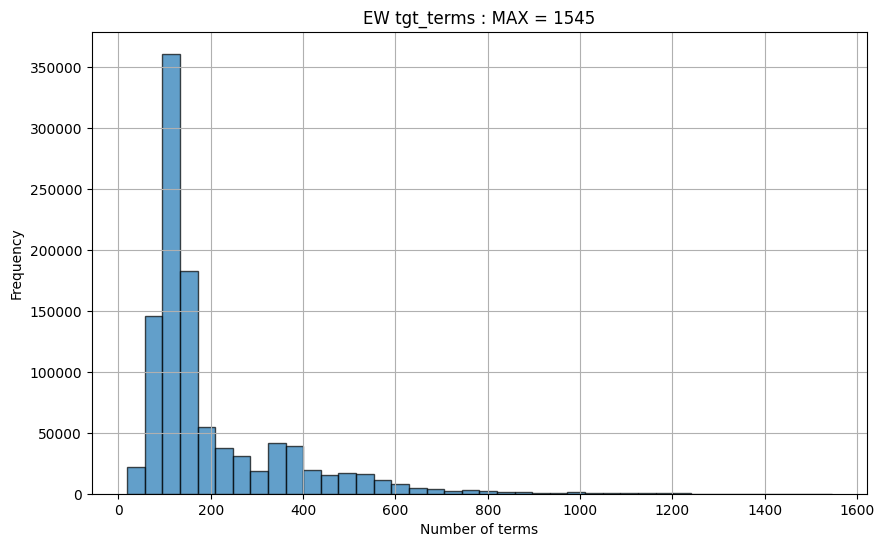

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(term_lens, bins=40, edgecolor='black', alpha=0.7)
plt.title(f'EW tgt_terms : MAX = {term_lens.max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [34]:
seq_lens = []

In [35]:
for exp in tqdm(df.sqamp.tolist()):
    seq_lens.append(len(tokenizer.tgt_tokenize(exp)))

100%|██████████| 5589/5589 [00:04<00:00, 1317.61it/s]


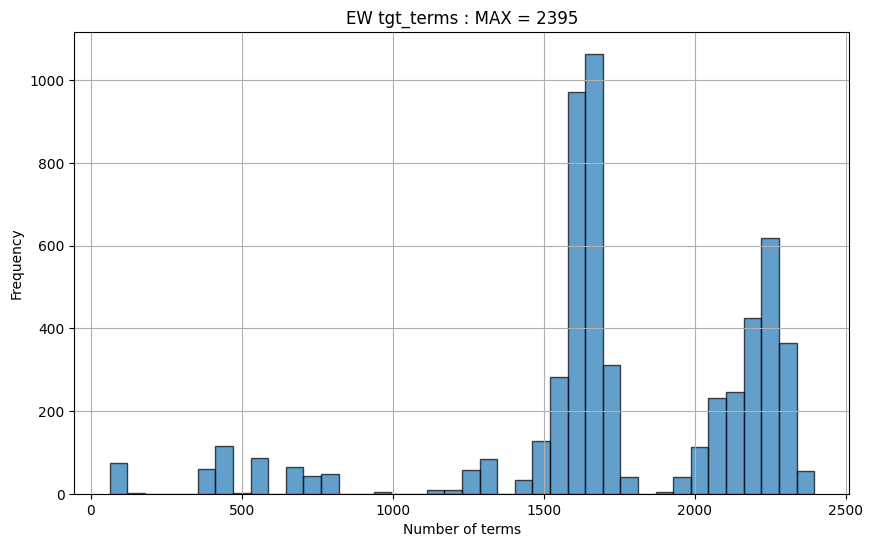

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(np.array(seq_lens), bins=40, edgecolor='black', alpha=0.7)
plt.title(f'EW tgt_terms : MAX = {np.array(seq_lens).max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()